Курсовая работа

04. Регрессия для SI

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.6 MB/s eta 0:00:00


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import joblib
import optuna
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [7]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [8]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


In [ ]:
# Выбираем целевую переменную (SI) и признаки для модели
y = df_standardscaler['SI']  # Целевая переменная
X = df_standardscaler.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки в соотношении 75:25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Словарь с классами регрессоров, которые будем оптимизировать
REGRESSORS = {
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'CatBoostRegressor': CatBoostRegressor
}

def objective(trial, regressor_name):
    """Оптимизация гиперпараметров."""
    if regressor_name == 'XGBRegressor':
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params)

    elif regressor_name == 'DecisionTreeRegressor':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeRegressor(**params)

    elif regressor_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestRegressor(**params)

    elif regressor_name == 'CatBoostRegressor':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0
        }
        model = CatBoostRegressor(**params)
    # Обучаем модель и делаем предсказания
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Оцениваем качество по метрике MSE
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Результаты лучшей модели для каждого алгоритма
best_models = {}
for regressor_name in REGRESSORS.keys():
    print(f"Оптимизация гиперпараметров для {regressor_name}...")
    study = optuna.create_study(direction='minimize')  # Минимизация MSE
    study.optimize(lambda trial: objective(trial, regressor_name), n_trials=200)
    # Получаем лучший набор параметров
    best_trial = study.best_trial
    best_model = REGRESSORS[regressor_name](**best_trial.params).fit(X_train, y_train)
    best_models[regressor_name] = {
        'best_params': best_trial.params,
        'best_model': best_model,
    }

    print(f"Оптимальные гиперпараметры для {regressor_name}:", best_trial.params)

# Оценка качества моделей на тестовых данных
for regressor_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовый MSE: {mse}, Тестовый MAE: {mae}, Тестовый R^2: {r2}")

[I 2025-06-14 17:42:46,388] A new study created in memory with name: no-name-2de377fb-af3b-4502-9236-f694add5b597


Оптимизация гиперпараметров для XGBRegressor...


[I 2025-06-14 17:42:52,525] Trial 0 finished with value: 1.5266688950745646 and parameters: {'learning_rate': 0.5920448429427924, 'max_depth': 15, 'n_estimators': 114, 'subsample': 0.6675647809449525, 'colsample_bytree': 0.7284574922784619}. Best is trial 0 with value: 1.5266688950745646.
[I 2025-06-14 17:42:52,871] Trial 1 finished with value: 1.1957471267563744 and parameters: {'learning_rate': 0.005785509767054313, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.6750672772884583, 'colsample_bytree': 0.7026601060362003}. Best is trial 1 with value: 1.1957471267563744.
[I 2025-06-14 17:43:11,879] Trial 2 finished with value: 1.1677497564909778 and parameters: {'learning_rate': 0.11144032239120506, 'max_depth': 14, 'n_estimators': 522, 'subsample': 0.9392499250880177, 'colsample_bytree': 0.833812764206048}. Best is trial 2 with value: 1.1677497564909778.
[I 2025-06-14 17:43:20,950] Trial 3 finished with value: 1.1475541997306888 and parameters: {'learning_rate': 0.004189480774443533

Оптимальные гиперпараметры для XGBRegressor: {'learning_rate': 0.1140617078644596, 'max_depth': 3, 'n_estimators': 86, 'subsample': 0.9701381744918415, 'colsample_bytree': 0.6455116866626311}
Оптимизация гиперпараметров для DecisionTreeRegressor...


[I 2025-06-14 17:49:54,463] Trial 4 finished with value: 1.4002204666866613 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 2 with value: 1.1694049382550107.
[I 2025-06-14 17:49:54,539] Trial 5 finished with value: 1.2040018829135457 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 1.1694049382550107.
[I 2025-06-14 17:49:54,605] Trial 6 finished with value: 1.3358901180931264 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 2 with value: 1.1694049382550107.
[I 2025-06-14 17:49:54,644] Trial 7 finished with value: 1.3295474470683182 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 1.1694049382550107.
[I 2025-06-14 17:49:54,688] Trial 8 finished with value: 1.2536426605017366 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 2 with 

Оптимальные гиперпараметры для DecisionTreeRegressor: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2}
Оптимизация гиперпараметров для RandomForestRegressor...


[I 2025-06-14 17:50:16,242] Trial 0 finished with value: 1.0460041841429095 and parameters: {'n_estimators': 201, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.0460041841429095.
[I 2025-06-14 17:50:29,511] Trial 1 finished with value: 1.0309304776651442 and parameters: {'n_estimators': 340, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 1 with value: 1.0309304776651442.
[I 2025-06-14 17:50:32,092] Trial 2 finished with value: 1.0868168682484431 and parameters: {'n_estimators': 80, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 1.0309304776651442.
[I 2025-06-14 17:50:37,600] Trial 3 finished with value: 1.0931603758252202 and parameters: {'n_estimators': 267, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 1.0309304776651442.
[I 2025-06-14 17:50:39,531] Trial 4 finished with value: 1.1096354210769563 and parameters: {'n_

Оптимальные гиперпараметры для RandomForestRegressor: {'n_estimators': 306, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 5}
Оптимизация гиперпараметров для CatBoostRegressor...


[I 2025-06-14 18:40:22,465] Trial 0 finished with value: 1.1333027008680234 and parameters: {'learning_rate': 0.04501432992180838, 'depth': 6, 'iterations': 288, 'l2_leaf_reg': 0.003947588588468379}. Best is trial 0 with value: 1.1333027008680234.
[I 2025-06-14 18:40:22,998] Trial 1 finished with value: 1.183455621810659 and parameters: {'learning_rate': 0.22899605979944712, 'depth': 1, 'iterations': 338, 'l2_leaf_reg': 0.007970609333877405}. Best is trial 0 with value: 1.1333027008680234.
[I 2025-06-14 18:40:24,061] Trial 2 finished with value: 1.2632815844517045 and parameters: {'learning_rate': 0.0017955376981853564, 'depth': 2, 'iterations': 342, 'l2_leaf_reg': 0.01680851754440934}. Best is trial 0 with value: 1.1333027008680234.
[I 2025-06-14 18:40:25,054] Trial 3 finished with value: 1.2429764148510873 and parameters: {'learning_rate': 0.001590378780796925, 'depth': 5, 'iterations': 74, 'l2_leaf_reg': 0.003190961365014806}. Best is trial 0 with value: 1.1333027008680234.
[I 2025-

0:	learn: 0.8812983	total: 59.9ms	remaining: 32.7s
1:	learn: 0.8347907	total: 142ms	remaining: 38.7s
2:	learn: 0.7911362	total: 203ms	remaining: 36.9s
3:	learn: 0.7565238	total: 268ms	remaining: 36.4s
4:	learn: 0.7165168	total: 335ms	remaining: 36.3s
5:	learn: 0.7033332	total: 396ms	remaining: 35.7s
6:	learn: 0.6744874	total: 459ms	remaining: 35.4s
7:	learn: 0.6579414	total: 522ms	remaining: 35.2s
8:	learn: 0.6524617	total: 584ms	remaining: 34.9s
9:	learn: 0.6486849	total: 643ms	remaining: 34.6s
10:	learn: 0.6437832	total: 706ms	remaining: 34.4s
11:	learn: 0.6352787	total: 770ms	remaining: 34.3s
12:	learn: 0.6280343	total: 829ms	remaining: 34.1s
13:	learn: 0.6253410	total: 890ms	remaining: 33.9s
14:	learn: 0.6185835	total: 951ms	remaining: 33.7s
15:	learn: 0.6158030	total: 1.02s	remaining: 33.8s
16:	learn: 0.6071446	total: 1.08s	remaining: 33.8s
17:	learn: 0.6022469	total: 1.17s	remaining: 34.3s
18:	learn: 0.6004423	total: 1.23s	remaining: 34.2s
19:	learn: 0.5960916	total: 1.29s	remain

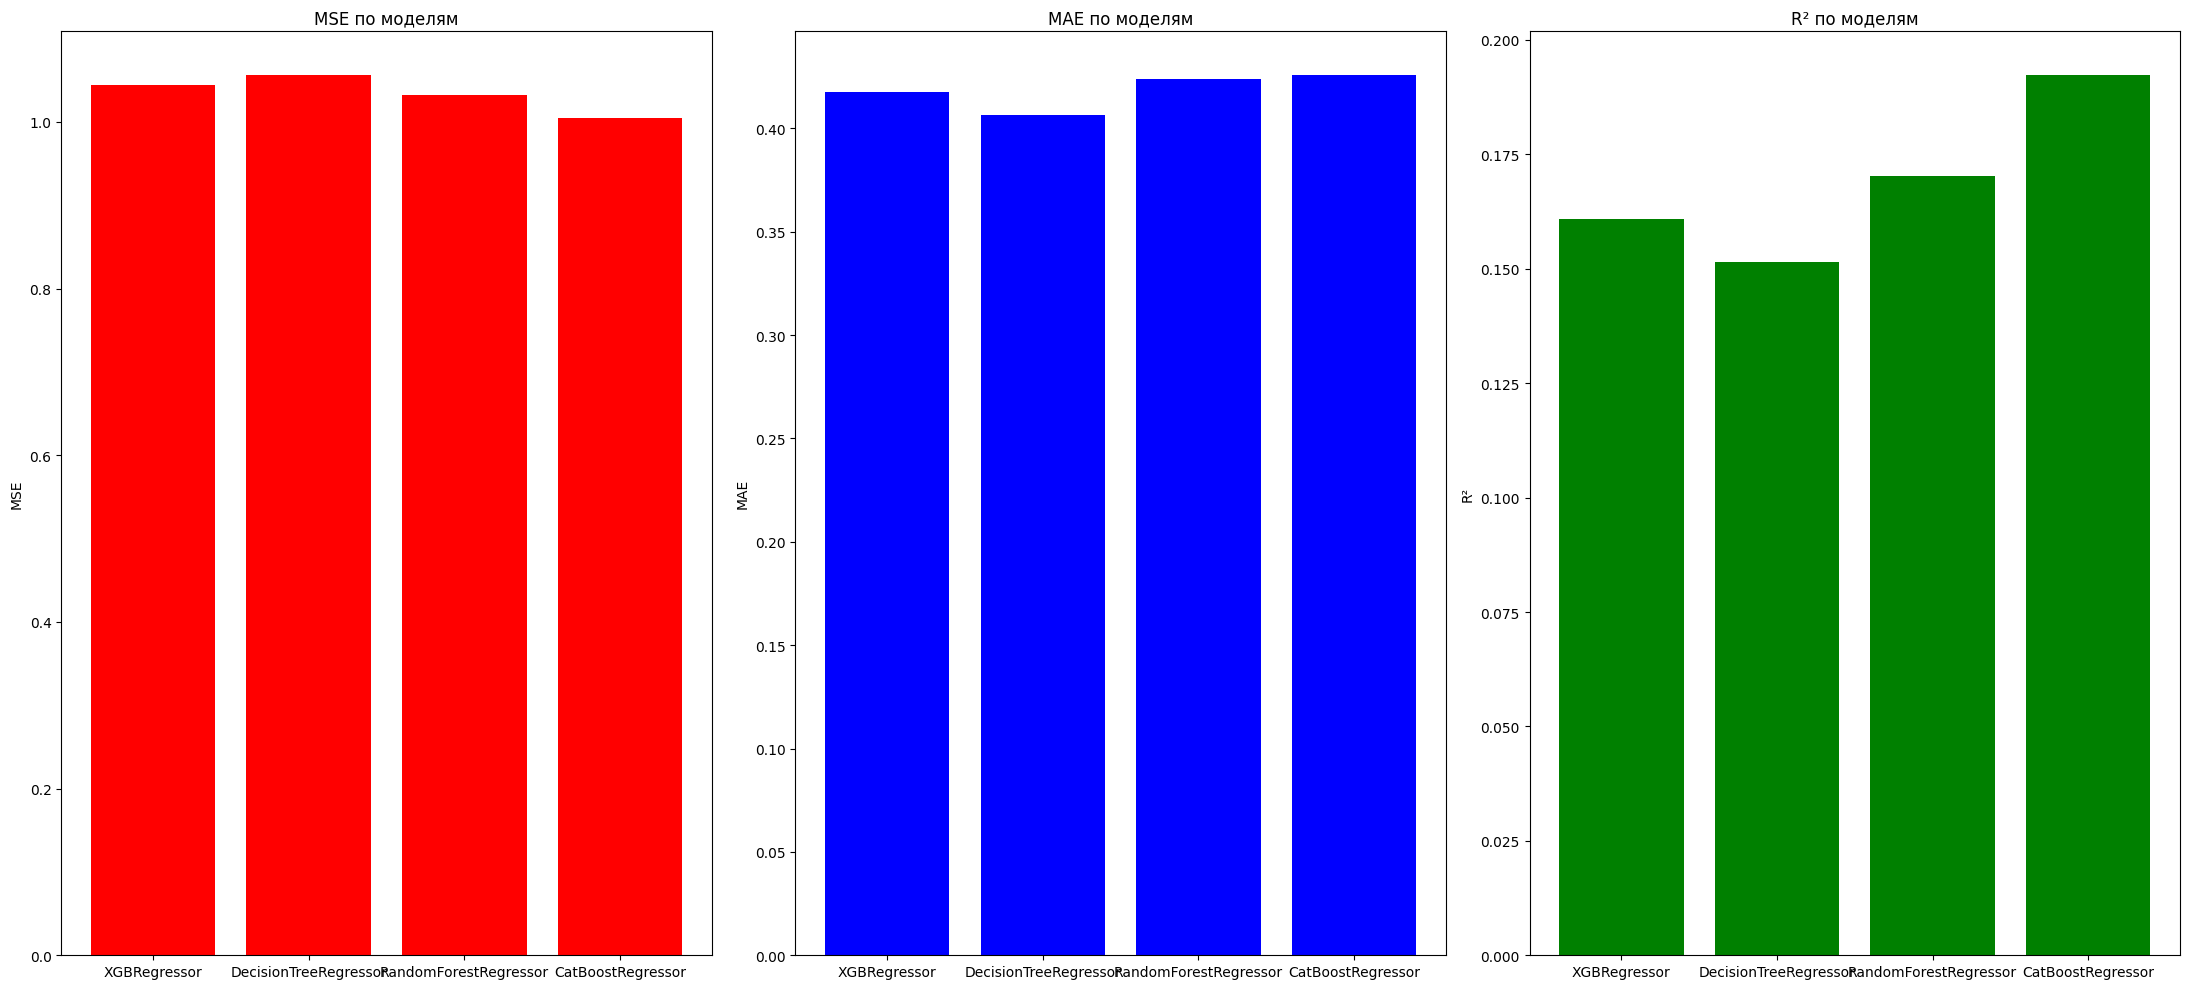

In [ ]:
# Сравненим качество регрессионных моделей с визуализацией результатов
def plot_results(models_metrics):
    model_names = list(models_metrics.keys())
    mse_values = [metrics[0] for metrics in models_metrics.values()]
    mae_values = [metrics[1] for metrics in models_metrics.values()]
    r2_values = [metrics[2] for metrics in models_metrics.values()]

    plt.figure(figsize=(22, 10))

    # График 1: MSE по моделям
    plt.subplot(1, 3, 1)
    plt.bar(model_names, mse_values, color='red')
    plt.title('MSE по моделям')
    plt.ylabel('MSE')

    # График 2: MAE по моделям
    plt.subplot(1, 3, 2)
    plt.bar(model_names, mae_values, color='blue')
    plt.title('MAE по моделям')
    plt.ylabel('MAE')

    # График 3: R² по моделям
    plt.subplot(1, 3, 3)
    plt.bar(model_names, r2_values, color='green')
    plt.title('R² по моделям')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

# Создадим словарь с метриками для каждой модели
metrics_dict = {name: (mse, mae, r2) for name, (mse, mae, r2) in zip(best_models.keys(), [(mean_squared_error(y_test, model_data['best_model'].predict(X_test)),
                       mean_absolute_error(y_test, model_data['best_model'].predict(X_test)),
                       r2_score(y_test, model_data['best_model'].predict(X_test)) ) for model_data in best_models.values()])}

plot_results(metrics_dict)

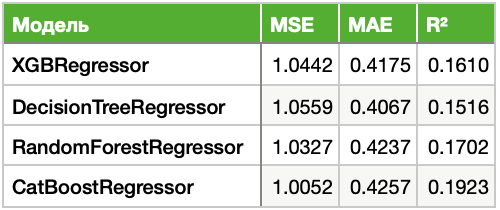

Выводы:

1. CatBoostRegressor показала наилучшее качество среди всех рассмотренных моделей по всем ключевым метрикам:

MSE = 1.0052

R² = 0.1923

Выбранны гиперпараметры:

learning_rate: 0.2338

depth: 8

iterations: 547

l2_leaf_reg: 0.0015

имеет наименьшее значение MSE, что говорит о лучшей точности предсказаний, демонстрирует наивысший R², что указывает на лучшую объясняющую способность модели.

2. RandomForestRegressor — показывает очень близкие значения MSE и R² к CatBoostRegressor.


3. XGBoostRegressor и DecisionTreeRegressor — средние результаты.
У XGBoostRegressor худший R², чем у Random Forest и CatBoost.
DecisionTreeRegressor имеет незначительно худшие метрики, особенно по сравнению с CatBoostRegressor.

In [ ]:
# Цикл для сохранения обученных моделей в файлы формата .pkl
for regressor_name, model_data in best_models.items():
    # Формируем имя файла на основе названия модели и целевой переменной (IC50)
    filename = f"{regressor_name}_IC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model_data['best_model'], file)
        print(f"Модель '{filename}' сохранена.")

# Загрузка модели из созданного pickle файла
def load_model(regressor_name):
    # Формируем имя файла на основе названия модели и целевой переменной
    filename = f"{regressor_name}_IC50.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Загрузка сохранённых моделей
loaded_xgb = load_model('XGBRegressor')           # XGBoost модель
loaded_dt = load_model('DecisionTreeRegressor')   # Дерево решений
loaded_rf = load_model('RandomForestRegressor')   # Случайный лес
loaded_catboost = load_model('CatBoostRegressor') # CatBoost модель

Модель 'XGBRegressor_IC50.pkl' сохранена.
Модель 'DecisionTreeRegressor_IC50.pkl' сохранена.
Модель 'RandomForestRegressor_IC50.pkl' сохранена.
Модель 'CatBoostRegressor_IC50.pkl' сохранена.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Словарь с загруженными моделями
loaded_models = {
    'XGBRegressor': loaded_xgb,
    'DecisionTreeRegressor': loaded_dt,
    'RandomForestRegressor': loaded_rf,
    'CatBoostRegressor': loaded_catboost
}

# Проверка всех загруженных моделей
for regressor_name, model in loaded_models.items():
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовые метрики после загрузки:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}\n")

XGBRegressor - Тестовые метрики после загрузки:
  MSE: 1.0442
  R²: 0.1610

DecisionTreeRegressor - Тестовые метрики после загрузки:
  MSE: 1.0559
  R²: 0.1516

RandomForestRegressor - Тестовые метрики после загрузки:
  MSE: 1.0327
  R²: 0.1702

CatBoostRegressor - Тестовые метрики после загрузки:
  MSE: 1.0052
  R²: 0.1923



In [ ]:
import os
# Проверяем все файлы в текущей директории
os.listdir()

['.config',
 'XGBRegressor_IC50.pkl',
 'CatBoostRegressor_IC50.pkl',
 'drive',
 'catboost_info',
 'DecisionTreeRegressor_IC50.pkl',
 'RandomForestRegressor_IC50.pkl',
 'sample_data']